In [1]:
import warnings

warnings.filterwarnings('ignore')

# !pip3 install catboost
# !pip3 install lightgbm
# !pip3 install category_encoders

import numpy as np
import pandas as pd
from numpy import mean
from numpy import isnan
from numpy import asarray
from numpy import polyfit
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import  MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

import category_encoders
from category_encoders import TargetEncoder

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
train = pd.read_csv('/content/sample_data/train.csv')
test = pd.read_csv('/content/sample_data/test.csv')
train.head()

ID City_Code  Region_Code  ... Reco_Policy_Cat Reco_Policy_Premium  Response
0   1        C3         3213  ...              22             11628.0         0
1   2        C5         1117  ...              22             30510.0         0
2   3        C5         3732  ...              19              7450.0         1
3   4       C24         4378  ...              19             17780.0         0
4   5        C8         2190  ...              16             10404.0         0

[5 rows x 14 columns]

In [3]:
train.set_index('ID', inplace=True)
test.set_index('ID', inplace=True)

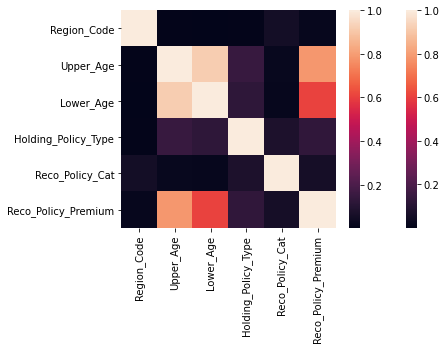

In [4]:
def eliminate_corr_columns(df):
    corr_matrix = df.corr().abs()
    sns.heatmap(corr_matrix)
    upper_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.8)]
    df_new = df.drop(to_drop, axis=1)
    return df_new

train = eliminate_corr_columns(train)
test = eliminate_corr_columns(test)

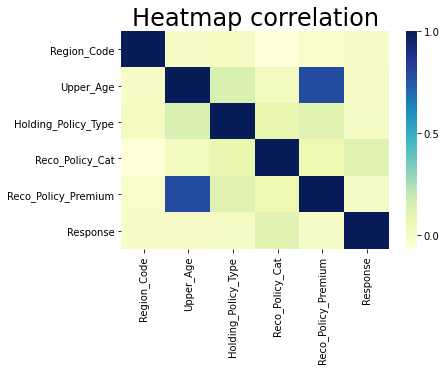

In [5]:
df_corr = train.corr()

sns.heatmap(df_corr, cmap='YlGnBu')
sns.set(font_scale=2,style='white')

plt.title('Heatmap correlation')
plt.show()

rank = df_corr['Response']
df_rank = pd.DataFrame(rank)
df_rank = np.abs(df_rank).sort_values(by='Response',ascending=False)
df_rank.dropna(inplace=True)

In [6]:
df_rank

Response
Response             1.000000
Reco_Policy_Cat      0.114321
Holding_Policy_Type  0.009297
Reco_Policy_Premium  0.007943
Upper_Age            0.002772
Region_Code          0.001121

In [7]:
train.columns

Index(['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Upper_Age', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration',
       'Holding_Policy_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium',
       'Response'],
      dtype='object')

In [8]:
# df_train_all = train[0:200000]
df_train_1 = train[train['Response'] == 1]
df_train_0 = train[train['Response'] == 0]
print('In this dataset, we have ' + str(len(df_train_1)) + "-" + str(len(df_train_0)) 
      +" Loanee so we need to take a similar number of non-loanee")

In this dataset, we have 12209-38673 Loanee so we need to take a similar number of non-loanee


In [9]:
df_sample = df_train_0.sample(12000)
df_train = df_train_1.append(df_sample) # We gather the frauds with the no frauds. 
df_train = df_train.sample(frac=1) # Then we mix our dataset
df_train.shape

(24209, 12)

In [10]:
train = df_train

In [11]:
train['Holding_Policy_Duration']= train['Holding_Policy_Duration'].str.replace("+", ".5")
test['Holding_Policy_Duration']= test['Holding_Policy_Duration'].str.replace("+", ".5")
train['Holding_Policy_Duration'] = train['Holding_Policy_Duration'].fillna(train['Holding_Policy_Duration'].median())
train['Holding_Policy_Type'] = train['Holding_Policy_Type'].fillna(train['Holding_Policy_Type'].median())
test['Holding_Policy_Duration'] = test['Holding_Policy_Duration'].fillna(test['Holding_Policy_Duration'].median())
test['Holding_Policy_Type'] = test['Holding_Policy_Type'].fillna(test['Holding_Policy_Type'].median())
train.isna().sum()

City_Code                     0
Region_Code                   0
Accomodation_Type             0
Reco_Insurance_Type           0
Upper_Age                     0
Is_Spouse                     0
Health Indicator           5515
Holding_Policy_Duration       0
Holding_Policy_Type           0
Reco_Policy_Cat               0
Reco_Policy_Premium           0
Response                      0
dtype: int64

In [12]:
train.drop('Health Indicator', axis=1, inplace=True)
test.drop('Health Indicator', axis=1, inplace=True)

In [13]:
te = TargetEncoder()
train['Region_Code_Encoding'] = te.fit_transform(train['Region_Code'] .astype(str), train['Response'])
sort_region = train.sort_values(['Region_Code', 'Region_Code_Encoding'], ascending = True)
region_unique = sort_region.groupby('Region_Code').first().reset_index()[['Region_Code', 'Region_Code_Encoding']]
region_dict =  dict(zip(region_unique.Region_Code, region_unique.Region_Code_Encoding))
test['Region_Code_Encoding'] = test['Region_Code'].map(region_dict)
test.head()

City_Code  Region_Code  ... Reco_Policy_Premium Region_Code_Encoding
ID                            ...                                         
50883        C1          156  ...             11934.0             0.733333
50884        C4            7  ...             32204.8             0.437500
50885        C1          564  ...              9240.0             0.166672
50886        C3         1177  ...              9086.0             0.500004
50887        C1          951  ...             22534.0             0.831131

[5 rows x 11 columns]

In [14]:
train.drop('Region_Code', axis=1, inplace=True)
test.drop('Region_Code', axis=1, inplace=True)

In [10]:
# le = LabelEncoder() 
# le.fit(train[["City_Code", "Accomodation_Type", "Reco_Insurance_Type", "Is_Spouse"]].stack().unique())
# le.fit(test[["City_Code", "Accomodation_Type", "Reco_Insurance_Type", "Is_Spouse"]].stack().unique())
# train['City_Code'] = le.transform(train['City_Code'])
# test['City_Code'] = le.transform(test['City_Code'])
# train['Accomodation_Type'] = le.transform(train['Accomodation_Type'])
# test['Accomodation_Type'] = le.transform(test['Accomodation_Type'])
# train['Reco_Insurance_Type'] = le.transform(train['Reco_Insurance_Type'])
# test['Reco_Insurance_Type'] = le.transform(test['Reco_Insurance_Type'])
# train['Is_Spouse'] = le.transform(train['Is_Spouse'])
# test['Is_Spouse'] = le.transform(test['Is_Spouse'])
# train.head()

In [15]:
train = pd.get_dummies(train, columns=["City_Code", "Accomodation_Type", "Reco_Insurance_Type", "Is_Spouse"])
train.head()

Upper_Age Holding_Policy_Duration  ...  Is_Spouse_No  Is_Spouse_Yes
ID                                        ...                             
37658         60                    14.5  ...             0              1
36091         32                       5  ...             0              1
43229         23                       5  ...             1              0
49541         27                       5  ...             1              0
31335         43                     5.0  ...             1              0

[5 rows x 49 columns]

In [16]:
test = pd.get_dummies(test, columns=["City_Code", "Accomodation_Type", "Reco_Insurance_Type", "Is_Spouse"])
test.head()

Upper_Age Holding_Policy_Duration  ...  Is_Spouse_No  Is_Spouse_Yes
ID                                        ...                             
50883         30                     6.0  ...             1              0
50884         69                     3.0  ...             0              1
50885         28                     2.0  ...             1              0
50886         23                     3.0  ...             1              0
50887         75                       5  ...             1              0

[5 rows x 48 columns]

In [17]:
df = train
df_test = test

columns = df.columns
tes_columns = df_test.columns

In [18]:
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = columns

In [19]:
x_test = df_test.values
x_test_scaled = min_max_scaler.fit_transform(x_test)
df_test = pd.DataFrame(x_test_scaled)
df_test.columns = tes_columns
df.head()

Upper_Age  Holding_Policy_Duration  ...  Is_Spouse_No  Is_Spouse_Yes
0   0.736842                 1.000000  ...           0.0            1.0
1   0.245614                 0.296296  ...           0.0            1.0
2   0.087719                 0.296296  ...           1.0            0.0
3   0.157895                 0.296296  ...           1.0            0.0
4   0.438596                 0.296296  ...           1.0            0.0

[5 rows x 49 columns]

In [20]:
X = df.drop('Response', axis=1)
y = df['Response']
X.head()

Upper_Age  Holding_Policy_Duration  ...  Is_Spouse_No  Is_Spouse_Yes
0   0.736842                 1.000000  ...           0.0            1.0
1   0.245614                 0.296296  ...           0.0            1.0
2   0.087719                 0.296296  ...           1.0            0.0
3   0.157895                 0.296296  ...           1.0            0.0
4   0.438596                 0.296296  ...           1.0            0.0

[5 rows x 48 columns]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16946, 48) (7263, 48) (16946,) (7263,)


LGBM

In [38]:
lgbmClf = LGBMClassifier(random_state=0)        ## num_leaves=31, n_estimators=400, max_depth=3,
lgbmClf.fit(X_train, y_train)
prediction = lgbmClf.predict(X_test)
y_pred = lgbmClf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.7728892759287186

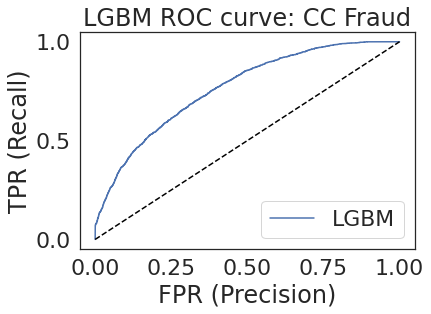

Area under curve (AUC):  0.7653338246533463


In [24]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.title('LGBM ROC curve: CC Fraud')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr, label='LGBM')
plt.legend(loc='lower right')
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr)) #roc_auc_score(y_test, y_score)

In [39]:
test_pred = lgbmClf.predict_proba(df_test)
test_pred_int = test_pred[:,1] >= 0.5
test_pred_int = test_pred_int.astype(np.int)
test['Response'] = test_pred_int

In [40]:
submission = test[['Response']]
submission.index = test.index
submission
submission.to_csv('sub_rs_cv_clf.csv', index=True)

In [41]:
from xgboost import XGBClassifier

In [29]:
xgbClf = XGBClassifier()
xgbClf.fit(X_train, y_train)
prediction = xgbClf.predict(X_test)
y_pred = xgbClf.predict_proba(X_test)[:,1]

In [30]:
print('Accuracy:',format(accuracy_score(y_test, prediction)*100))
print('AUC:',format(roc_auc_score(y_test, y_pred)*100))
print('Classification_report:',classification_report(y_test, prediction))

Accuracy: 67.2063439616719
AUC: 75.37871492521018
Classification_report:               precision    recall  f1-score   support

         0.0       0.68      0.63      0.66      3000
         1.0       0.66      0.71      0.69      3053

    accuracy                           0.67      6053
   macro avg       0.67      0.67      0.67      6053
weighted avg       0.67      0.67      0.67      6053



In [31]:
test_pred = xgbClf.predict_proba(df_test)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['Response'] = test_pred_int

In [32]:
submission = test[['Response']]
submission.index = test.index
submission
submission.to_csv('sub_xgbclf.csv', index=True)

In [35]:
rf_clf = RandomForestClassifier(n_estimators = 500, min_samples_split = 8, 
                                max_depth = 8, class_weight= 'balanced', criterion='gini', random_state=42)# Fitting the dataset
rf_clf.fit(X_train, y_train)
prediction = rf_clf.predict(X_test)
y_pred = rf_clf.predict_proba(X_test)[:,1]

In [36]:
print('Accuracy:',format(accuracy_score(y_test, prediction)*100))
print('AUC:',format(roc_auc_score(y_test, y_pred)*100))
print('Classification_report:',classification_report(y_test, prediction))

Accuracy: 66.03337188171155
AUC: 74.20256578229065
Classification_report:               precision    recall  f1-score   support

         0.0       0.65      0.69      0.67      3000
         1.0       0.67      0.64      0.65      3053

    accuracy                           0.66      6053
   macro avg       0.66      0.66      0.66      6053
weighted avg       0.66      0.66      0.66      6053

